## Regrid ERA5 files to CRCM5 res05 grid

In [10]:
import xarray as xr
import numpy as np
import dask
from dask.diagnostics import ProgressBar
from dask.distributed import Client
import glob
import time

# my function files
import sys
# sys.path.append('/home/portal/script/python/precip_Cristina/')
sys.path.append('/home/alice/Desktop/work/git/myISACcode/python/precip_Cristina')
import functions_analogues_PrMax as fanPM

In [11]:
varname = 'z'
varstr = 'z500'
# data_dir = '/work_big/users/clima/portal/'                  # alice
data_dir = '/media/alice/Crucial X9/portal/data_CNR/'    # tintin
year_range = [1985, 2024]   # for reference climatology
# box on which to compute trends parameters
box_trend = [0,30,30,50]  # [lon_min, lon_max, lat_min, lat_max]
# rolling mean window (days)
dt_rolling = 91

### File selection

In [12]:
# Define the file pattern
file_pattern = data_dir + 'ERA5/' + varstr + "/res05/ERA5_"+varstr+"_NH_daily_????_anom_regridded-to-CRCM5.nc"
# Get all file paths matching the pattern
all_files = glob.glob(file_pattern)
# Select and sort files
selected_files = []
for year in range(year_range[0], year_range[1]+1):
    selected_files += [file for file in all_files if str(year) in file]
selected_files = sorted(selected_files)
print(selected_files[-5:])
print(sorted(all_files)[-5:])

['/media/alice/Crucial X9/portal/data_CNR/ERA5/z500/res05/ERA5_z500_NH_daily_2020_anom_regridded-to-CRCM5.nc', '/media/alice/Crucial X9/portal/data_CNR/ERA5/z500/res05/ERA5_z500_NH_daily_2021_anom_regridded-to-CRCM5.nc', '/media/alice/Crucial X9/portal/data_CNR/ERA5/z500/res05/ERA5_z500_NH_daily_2022_anom_regridded-to-CRCM5.nc', '/media/alice/Crucial X9/portal/data_CNR/ERA5/z500/res05/ERA5_z500_NH_daily_2023_anom_regridded-to-CRCM5.nc', '/media/alice/Crucial X9/portal/data_CNR/ERA5/z500/res05/ERA5_z500_NH_daily_2024_anom_regridded-to-CRCM5.nc']
['/media/alice/Crucial X9/portal/data_CNR/ERA5/z500/res05/ERA5_z500_NH_daily_2020_anom_regridded-to-CRCM5.nc', '/media/alice/Crucial X9/portal/data_CNR/ERA5/z500/res05/ERA5_z500_NH_daily_2021_anom_regridded-to-CRCM5.nc', '/media/alice/Crucial X9/portal/data_CNR/ERA5/z500/res05/ERA5_z500_NH_daily_2022_anom_regridded-to-CRCM5.nc', '/media/alice/Crucial X9/portal/data_CNR/ERA5/z500/res05/ERA5_z500_NH_daily_2023_anom_regridded-to-CRCM5.nc', '/media/

### Compute daily trend over selected years in box

In [13]:
# Weights for area average
latitudes = np.arange(box_trend[2], box_trend[3]+0.5, 0.5)
weights = np.cos(np.deg2rad(latitudes))
weights = xr.DataArray(weights, coords=[latitudes], dims=["lat"])
# Trend function
def linear_trend(y, x):
    return xr.polyfit(y, dim="year", deg=1, x=x).polyfit_coefficients.sel(degree=1)

In [14]:
### Compute daily trend over selected years in box
data_box_avg = []
for iy, year in enumerate(range(year_range[0], year_range[1]+1)):
    print(f"Loading data for year {year}...")
    # Upload data
    data_y = xr.open_dataset(selected_files[iy])
    # Compute area average weighted by cosine latitude 
    data_y_box_avg = data_y[varname].sel(lon=slice(box_trend[0], box_trend[1]), lat=slice(box_trend[2], box_trend[3]))
    data_y_box_avg = data_y_box_avg.weighted(weights).mean(dim=['lon','lat'])
    data_box_avg += [data_y_box_avg]
data_box_avg = xr.concat(data_box_avg, dim='time').sortby('time')

# Compute linear trend
# Data
da = data_box_avg.copy()
da_rolling = da.rolling(time=dt_rolling, center=True).mean() # Smooth data with 61-day rolling mean
# Time in years from 0 and DOY
years_from0 = np.arange(year_range[0], year_range[1]+1) - year_range[0]
doys = np.arange(1, 366)  # 1-365
# Initialize arrays to hold daily slope and intercept
daily_slope = np.full(len(doys), np.nan)
daily_intercept = np.full(len(doys), np.nan)

for i, doy in enumerate(doys):
    # Select all data for this DOY across years
    mask_doy = da_rolling.time.dt.dayofyear == doy
    # Get x and y
    y = np.array(da_rolling.values[mask_doy]).flatten()
    x = np.array(years_from0)
    mask_nan = ~np.isnan(x) & ~np.isnan(y)
    # Fit linear model
    coeffs = np.polyfit(x[mask_nan], y[mask_nan], 1)
    daily_slope[i] = coeffs[0]  # slope in units per year
    daily_intercept[i] = coeffs[1]

print(daily_slope[:100])

Loading data for year 1985...
Loading data for year 1986...
Loading data for year 1987...
Loading data for year 1988...
Loading data for year 1989...
Loading data for year 1990...
Loading data for year 1991...
Loading data for year 1992...
Loading data for year 1993...
Loading data for year 1994...
Loading data for year 1995...
Loading data for year 1996...
Loading data for year 1997...
Loading data for year 1998...
Loading data for year 1999...
Loading data for year 2000...
Loading data for year 2001...
Loading data for year 2002...
Loading data for year 2003...
Loading data for year 2004...
Loading data for year 2005...
Loading data for year 2006...
Loading data for year 2007...
Loading data for year 2008...
Loading data for year 2009...
Loading data for year 2010...
Loading data for year 2011...
Loading data for year 2012...
Loading data for year 2013...
Loading data for year 2014...
Loading data for year 2015...
Loading data for year 2016...
Loading data for year 2017...
Loading da

In [15]:
# # check min values over dataset
# vals = da_rolling.values.flatten()
# mask_nan = ~np.isnan(vals)
# vals = vals[mask_nan]
# idx20 = np.argsort(vals)[:40]
# print(idx20)
# print(da_rolling.time.values[mask_nan][idx20])
# print(da_rolling.values[mask_nan][idx20].flatten())

# look at values for day with min slope
print(daily_slope.argmin())
print(daily_slope.min())
doy_min = doys[daily_slope.argmin()]
mask_doy_min = da_rolling.time.dt.dayofyear == doy_min
values_doy_min = da_rolling.values[mask_doy_min].flatten()
coeffs = np.polyfit(years_from0[1:], values_doy_min[1:], 1)
print(coeffs) 

363
1.2486958750605752
[nan nan]


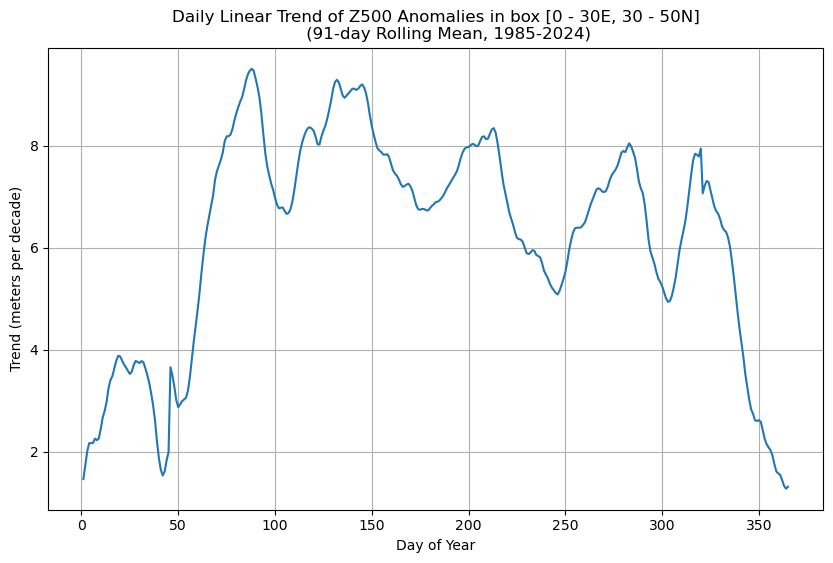

In [16]:
# plot profile daily slope
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(doys, daily_slope*10/9.81)
plt.xlabel('Day of Year')
plt.ylabel('Trend (meters per decade)')
if dt_rolling > 1:
    str_rolling = f'{dt_rolling}-day Rolling Mean'
else:
    str_rolling = 'daily data'
plt.title(
    f'Daily Linear Trend of Z500 Anomalies in box [{box_trend[0]} - {box_trend[1]}E, {box_trend[2]} - {box_trend[3]}N]\n \
    ({str_rolling}, 1985-2024)'
    )
plt.grid()
plt.show()  

In [19]:
# Save daily slope to npy file
np.save(f"{data_dir}ERA5/{varstr}/res05/ERA5_z500_NH_daily_sm{dt_rolling}d_{year_range[0]}-{year_range[1]}_trend_regridded-to-CRCM5.npy", daily_slope)

In [ ]:
# Save detrended data files for each year
for iy, year in enumerate(range(year_range[0], year_range[1]+1)):
    print(f"Loading data for year {year}...")
    # Upload data
    data_y = xr.open_dataset(selected_files[iy])
    data_y_detrended = data_y.copy()
    detrended_values = np.empty_like(data_y[varname].values)
    # Compute detrended values
    detrended_values = data_y[varname].values - (daily_slope * (year - year_range[0]) + daily_intercept)[:, np.newaxis, np.newaxis, np.newaxis]
    data_y_detrended[varname].values = detrended_values
    # # Print data_y and data_y_detrended for check
    # if year%10 == 0:
    #     print(data_y[varname].isel(time=100).max())
    #     print(data_y_detrended[varname].isel(time=100).max())
    # Save to netcdf
    data_y_detrended.to_netcdf(f"{data_dir}ERA5/{varstr}/res05/ERA5_{varstr}_NH_daily_{year}_anom_detrended_regridded-to-CRCM5.nc", mode='w', format='NETCDF4', engine='netcdf4')

Loading data for year 1985...
Loading data for year 1986...
Loading data for year 1987...
Loading data for year 1988...
Loading data for year 1989...
Loading data for year 1990...
<xarray.DataArray 'z' ()> Size: 4B
array(1473.418, dtype=float32)
Coordinates:
    time     object 8B 1990-04-11 09:00:00
<xarray.DataArray 'z' ()> Size: 8B
array(1623.15842661)
Coordinates:
    time     object 8B 1990-04-11 09:00:00
Loading data for year 1991...
Loading data for year 1992...
Loading data for year 1993...
Loading data for year 1994...
Loading data for year 1995...
Loading data for year 1996...
Loading data for year 1997...
Loading data for year 1998...
Loading data for year 1999...
Loading data for year 2000...
<xarray.DataArray 'z' ()> Size: 4B
array(1623.7773, dtype=float32)
Coordinates:
    time     object 8B 2000-04-11 09:00:00
<xarray.DataArray 'z' ()> Size: 8B
array(1706.31515664)
Coordinates:
    time     object 8B 2000-04-11 09:00:00
Loading data for year 2001...
Loading data for year